In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import StackingClassifier
from scipy.stats import mode
from catboost import CatBoostClassifier, Pool
from skopt import BayesSearchCV
import torch
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.metrics import log_loss
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_curve
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
# !pip install optbinning
# from optbinning import OptimalBinning, Scorecard, BinningProcess
import gc 
import math
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import f1_score

In [2]:
import dask
import dask.dataframe as dd
import numpy as np
import pandas as pd
import os
import time

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16,9]

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/talkingdata-adtracking-fraud-detection/sample_submission.csv
/kaggle/input/talkingdata-adtracking-fraud-detection/train_sample.csv
/kaggle/input/talkingdata-adtracking-fraud-detection/test_supplement.csv
/kaggle/input/talkingdata-adtracking-fraud-detection/train.csv
/kaggle/input/talkingdata-adtracking-fraud-detection/test.csv


In [3]:
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'object',
        'device'        : 'object',
        'os'            : 'object',
        'channel'       : 'object',
        'click_time'    : 'object',
        'is_attributed' : 'uint8',
        }

In [4]:
#Sample data - (100000, 8)
#click_data = pd.read_csv('../input/talkingdata-adtracking-fraud-detection/train_sample.csv', parse_dates=['click_time'])

#Full data - No idea how large it is, this notebook can not handle its size in RAM

#Read only first limit rows
#limit = 20_000_000

#Read only these columns - skip attributed_time 
usecols = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'is_attributed']

## Competition data

In [5]:
competition_data = dd.read_csv('../input/talkingdata-adtracking-fraud-detection/train.csv', 
                               dtype=dtypes,
                               #nrows=limit, #not supported by `dd.read_csv`
                               usecols=usecols, 
                               parse_dates=['click_time'])

In [6]:
competition_data.info()

<class 'dask_expr.DataFrame'>
Columns: 7 entries, ip to is_attributed
dtypes: uint32(1), uint8(1), string(5)

In [7]:
competition_data_postitive = competition_data[competition_data.is_attributed == 1] 

In [8]:
start_time = time.time()
type(competition_data_postitive)
print("--- %s seconds ---" % (time.time() - start_time))

--- 7.510185241699219e-05 seconds ---


In [9]:
start_time = time.time()
competition_data_postitive = competition_data_postitive.compute()
print("--- %s seconds ---" % (time.time() - start_time))

--- 657.9233505725861 seconds ---


In [10]:
competition_data_postitive.sample(10)

,ip,app,device,os,channel,click_time,is_attributed
394515,46571,45,1,8,5,2017-11-07 08:30:36,1
6457,38684,35,1,13,21,2017-11-07 02:52:45,1
1213204,79827,19,0,50,213,2017-11-08 03:49:50,1
667534,183333,9,1,13,134,2017-11-08 00:46:43,1
931312,45169,9,1,19,258,2017-11-07 02:09:13,1
305311,90626,35,1,15,21,2017-11-06 17:53:19,1
201963,242198,72,1,13,101,2017-11-08 04:27:18,1
1471800,108881,29,1,18,213,2017-11-08 10:52:18,1
368043,160318,19,0,38,213,2017-11-07 11:34:14,1
508657,5314,20,1,22,478,2017-11-08 12:25:46,1


In [11]:
competition_data_negative = competition_data[competition_data.is_attributed == 0] 

In [12]:
competition_data_negative = competition_data_negative.sample(frac=0.0025) #number

In [13]:
start_time = time.time()
competition_data_negative = competition_data_negative.compute()
print("--- %s seconds ---" % (time.time() - start_time))

--- 848.9710412025452 seconds ---


In [14]:
competition_data_negative.sample(10)

,ip,app,device,os,channel,click_time,is_attributed
705518,73839,3,1,1,115,2017-11-08 16:04:29,0
114145,74469,18,1,19,107,2017-11-07 02:54:51,0
493215,48321,13,1,13,477,2017-11-07 09:38:23,0
681702,23320,12,1,13,178,2017-11-09 08:57:23,0
1575733,9383,2,1,19,237,2017-11-08 07:52:37,0
97799,191882,3,1,10,409,2017-11-06 17:41:08,0
531428,121359,46,0,50,347,2017-11-08 23:15:29,0
1266431,86155,2,1,47,469,2017-11-09 15:20:34,0
518628,91536,12,2,20,178,2017-11-07 02:01:19,0
701311,328755,12,1,31,259,2017-11-09 05:07:03,0


In [15]:
competition_data = pd.concat([competition_data_postitive, competition_data_negative])

In [16]:
train, test, train_labels, test_labels = train_test_split(competition_data, competition_data.is_attributed, test_size=0.3, random_state=42)


## Feature Engineering 1 Construct features from timestamps

Notice that the `click_data` DataFrame has a `'click_time'` column with timestamp data.

Use this column to create features for the coresponding day, hour, minute and second. 

Store these as new integer columns `day`, `hour`, `minute`, and `second` in a new DataFrame `clicks`.

In [17]:
# Add new columns for timestamp features day, hour, minute, and second
train['click_time'] = pd.to_datetime(train['click_time'])
train['day'] = train['click_time'].dt.day.astype('uint8')
# Fill in the rest
train['hour'] = train['click_time'].dt.hour.astype('uint8')
train['minute'] = train['click_time'].dt.minute.astype('uint8')
train['second'] = train['click_time'].dt.second.astype('uint8')


In [18]:

# Add new columns for timestamp features day, hour, minute, and second
test['click_time'] = pd.to_datetime(test['click_time'])
test['day'] = test['click_time'].dt.day.astype('uint8')
# Fill in the rest
test['hour'] = test['click_time'].dt.hour.astype('uint8')
test['minute'] = test['click_time'].dt.minute.astype('uint8')
test['second'] = test['click_time'].dt.second.astype('uint8')

In [19]:
# store the label
train_labels = train.is_attributed.values
test_labels = test.is_attributed.values

# drop labels and attributed_time since it represnets the same info as the is_attributed
train.drop(labels = ['click_time','is_attributed'], axis = 1, inplace = True)
test.drop(labels = ['click_time', 'is_attributed'], axis = 1, inplace = True)

In [20]:
train = train.fillna(train.max())
test = test.fillna(test.max())

In [21]:
def evaluate():
  
  fpr, tpr, _ = metrics.roc_curve(test_labels,  y_pred_proba)

  # Plot the ROC curve
  plt.plot(fpr, tpr, color='blue', label='ROC Curve')

  # Fill below the ROC curve with color
  plt.fill_between(fpr, 0, tpr, color='skyblue', alpha=0.2)

  # Plot the diagonal line (y=x) for reference
  plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Chance')

  # Add labels and title
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.title('ROC Curve')
    

  # Show the plot
  plt.show()

In [22]:
results = []

## Feature Engineering

In [23]:
train, test, train_labels, test_labels = train_test_split(competition_data, competition_data.is_attributed, test_size=0.3, random_state=42)


In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 642575 entries, 666879 to 1232102
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ip             642575 non-null  uint32
 1   app            642575 non-null  object
 2   device         642575 non-null  object
 3   os             642575 non-null  object
 4   channel        642575 non-null  object
 5   click_time     642575 non-null  object
 6   is_attributed  642575 non-null  uint8 
dtypes: object(5), uint32(1), uint8(1)
memory usage: 32.5+ MB


In [25]:
# Add new columns for timestamp features day, hour, minute, and second
train['click_time'] = pd.to_datetime(train['click_time'])
train['day'] = train['click_time'].dt.day.astype('uint8')
# Fill in the rest
train['hour'] = train['click_time'].dt.hour.astype('uint8')
train['minute'] = train['click_time'].dt.minute.astype('uint8')
train['second'] = train['click_time'].dt.second.astype('uint8')

# Add new columns for timestamp features day, hour, minute, and second
test['click_time'] = pd.to_datetime(test['click_time'])
test['day'] = test['click_time'].dt.day.astype('uint8')
# Fill in the rest
test['hour'] = test['click_time'].dt.hour.astype('uint8')
test['minute'] = test['click_time'].dt.minute.astype('uint8')
test['second'] = test['click_time'].dt.second.astype('uint8')

In [26]:
def do_prev_Click( df,agg_suffix='prevClick', agg_type='float32'):

    print(f">> \nExtracting {agg_suffix} time calculation features...\n")
    
    GROUP_BY_NEXT_CLICKS = [
 
    {'groupby': ['ip', 'channel']},
    {'groupby': ['ip', 'os']},
  
    ]

    # Calculate the time to next click for each group
    for spec in GROUP_BY_NEXT_CLICKS:
    
       # Name of new feature
        new_feature = '{}_{}'.format('_'.join(spec['groupby']),agg_suffix)    
    
        # Unique list of features to select
        all_features = spec['groupby'] + ['click_time']

        # Run calculation
        print(f">> Grouping by {spec['groupby']}, and saving time to {agg_suffix} in: {new_feature}")
        df[new_feature] = (df.click_time - df[all_features].groupby(spec[
                'groupby']).click_time.shift(+1) ).dt.seconds.astype(agg_type)
        
        gc.collect()
    return (df)   

In [27]:
# train
train['day'] = train['click_time'].dt.day.astype('uint8')
train['hour'] = train['click_time'].dt.hour.astype('uint8')

# test
test['day'] = test['click_time'].dt.day.astype('uint8')
test['hour'] = test['click_time'].dt.hour.astype('uint8')

df_concat = pd.concat([train, test], ignore_index=True)
df_concat['day'] = df_concat['click_time'].dt.day.astype('uint8')
df_concat['hour'] = df_concat['click_time'].dt.hour.astype('uint8')

In [28]:
most_freq_hours_in_test_data = [4, 5, 9, 10, 13, 14]
least_freq_hours_in_test_data = [6, 11, 15]

train['in_test_hh'] = (
    3 - 2 * train.hour.isin(most_freq_hours_in_test_data)
      - 1 * train.hour.isin(least_freq_hours_in_test_data)
).astype('uint8')

test['in_test_hh'] = (
    3 - 2 * test.hour.isin(most_freq_hours_in_test_data)
      - 1 * test.hour.isin(least_freq_hours_in_test_data)
).astype('uint8')

df_concat['in_test_hh'] = (
    3 - 2 * df_concat.hour.isin(most_freq_hours_in_test_data)
      - 1 * df_concat.hour.isin(least_freq_hours_in_test_data)
).astype('uint8')

In [29]:
group = ['ip', 'day', 'in_test_hh']
df = df_concat.groupby(group).size().astype('uint16')
df = pd.DataFrame(df, columns=['ip_day_test_hh_clicks']).reset_index()
train = train.merge(df, how='left', on=group)
test = test.merge(df, how='left', on=group)

In [30]:
# ip_app_device_clicks
group = ['ip', 'app', 'device']
df = df_concat.groupby(group).size().astype('uint16')
df = pd.DataFrame(df, columns=['ip_app_device_clicks']).reset_index()
train = train.merge(df, how='left', on=group)
test = test.merge(df, how='left', on=group)

# ip_app_device_day_clicks
group = ['ip', 'app', 'device', 'day']
df = df_concat.groupby(group).size().astype('uint16')
df = pd.DataFrame(df, columns=['ip_app_device_day_clicks']).reset_index()
train = train.merge(df, how='left', on=group)
test = test.merge(df, how='left', on=group)

In [31]:
# single 'ip' grouper for ['app', 'device', 'channel']
count_cols = ['app', 'device', 'channel', 'hour']
group = 'ip'
for col in count_cols:
    df = df_concat.groupby(group)[col].nunique().astype('uint16')
    df.name = 'ip_nunique_{}'.format(col)
    df = pd.DataFrame(df).reset_index()
    train = train.merge(df, how='left', on=group)
    test = test.merge(df, how='left', on=group)
    #####################
    # self-add
    group_day = ['ip', 'day']
    df = df_concat.groupby(group_day)[col].nunique().astype('uint16')
    df.name = 'ip_day_nunique_{}'.format(col)
    df = pd.DataFrame(df).reset_index()
    train = train.merge(df, how='left', on=group_day)
    test = test.merge(df, how='left', on=group_day)
    #####################
    
# single 'app' grouper for 'channel'
group = 'app'
col = 'channel'
df = df_concat.groupby(group)[col].nunique().astype('uint16')
df.name = 'app_nunique_{}'.format(col)
df = pd.DataFrame(df).reset_index()
train = train.merge(df, how='left', on=group)
test = test.merge(df, how='left', on=group)
#####################

# self-add
group_day = ['app', 'day']
col = 'channel'
df = df_concat.groupby(group_day)[col].nunique().astype('uint16')
df.name = 'app_day_nunique_{}'.format(col)
df = pd.DataFrame(df).reset_index()
train = train.merge(df, how='left', on=group_day)
test = test.merge(df, how='left', on=group_day)
#####################

# duble ['ip', 'app'] grouper for 'os'
group = ['ip', 'app']
col = 'os'
df = df_concat.groupby(group)[col].nunique().astype('uint16')
df.name = 'ip_app_nunique_{}'.format(col)
df = pd.DataFrame(df).reset_index()
train = train.merge(df, how='left', on=group)
test = test.merge(df, how='left', on=group)
#####################

# self-add
group_day = ['ip', 'app', 'day']
col = 'os'
df = df_concat.groupby(group_day)[col].nunique().astype('uint16')
df.name = 'ip_app_day_nunique_{}'.format(col)
df = pd.DataFrame(df).reset_index()
train = train.merge(df, how='left', on=group_day)
test = test.merge(df, how='left', on=group_day)
#####################

# triple ['ip', 'device', 'os'] grouper for 'app'
group = ['ip', 'device', 'os']
col = 'app'
df = df_concat.groupby(group)[col].nunique().astype('uint16')
df.name = 'ip_device_os_nunique_{}'.format(col)
df = pd.DataFrame(df).reset_index()
train = train.merge(df, how='left', on=group)
test = test.merge(df, how='left', on=group)
#####################

# self-add
group_day = ['ip', 'device', 'os'] + ['day']
col = 'app'
df = df_concat.groupby(group_day)[col].nunique().astype('uint16')
df.name = 'ip_device_os_day_nunique_{}'.format(col)
df = pd.DataFrame(df).reset_index()
train = train.merge(df, how='left', on=group_day)
test = test.merge(df, how='left', on=group_day)
#####################

In [32]:
# Define all the groupby transformations
GROUPBY_AGGREGATIONS = [
    # Variance in day, for ip-app-channel
    {'groupby': ['ip','app','channel'], 'select': 'day', 'agg': 'var', 'type': 'float32'},
    # Variance in day, for ip-app-device
    {'groupby': ['ip','app','device'], 'select': 'day', 'agg': 'var', 'type': 'float32'},
    # Variance in day, for ip-app-os
    {'groupby': ['ip','app','os'], 'select': 'day', 'agg': 'var', 'type': 'float32'},
   # Count, for ip-day-hour
#     {'groupby': ['ip','day','hour'], 'select': 'channel', 'agg': 'count', 'type': 'float32'},
    # Count, for ip-day-hour
     {'groupby': ['channel'], 'select': 'day', 'agg': 'var', 'type': 'float32'},
    # Count, for ip-day-hour
   {'groupby': ['os'], 'select': 'hour', 'agg': 'var', 'type': 'float32'},
    {'groupby': ['ip','app','os','device'], 'select': 'hour', 'agg': 'var', 'type': 'float32'},
    {'groupby': ['ip','app','os'], 'select': 'hour', 'agg': 'var', 'type': 'float32'},

    # Mean hour, for ip-app-channel
    {'groupby': ['ip','app','channel'], 'select': 'hour', 'agg': 'mean', 'type': 'float32', 'type': 'float32'},
    {'groupby': ['channel'], 'select': 'hour', 'agg': 'mean', 'type': 'float32', 'type': 'float32'}

]
# Apply all the groupby transformations
for spec in GROUPBY_AGGREGATIONS:
    print(f"Grouping by {spec['groupby']}, and aggregating {spec['select']} with {spec['agg']}")
    
    # Unique list of features to select
    all_features = list(set(spec['groupby'] + [spec['select']]))
    # Name of new feature
    new_feature = '{}_{}'.format('_'.join(spec['groupby']), spec['agg'])
     # Perform the groupby
    gp = train[all_features]. \
        groupby(spec['groupby'])[spec['select']]. \
        agg(spec['agg']). \
        reset_index(). \
        rename(index=str, columns={spec['select']: new_feature}).astype(spec['type'])
    gp = test[all_features]. \
        groupby(spec['groupby'])[spec['select']]. \
        agg(spec['agg']). \
        reset_index(). \
        rename(index=str, columns={spec['select']: new_feature}).astype(spec['type'])


Grouping by ['ip', 'app', 'channel'], and aggregating day with var
Grouping by ['ip', 'app', 'device'], and aggregating day with var
Grouping by ['ip', 'app', 'os'], and aggregating day with var
Grouping by ['channel'], and aggregating day with var
Grouping by ['os'], and aggregating hour with var
Grouping by ['ip', 'app', 'os', 'device'], and aggregating hour with var
Grouping by ['ip', 'app', 'os'], and aggregating hour with var
Grouping by ['ip', 'app', 'channel'], and aggregating hour with mean
Grouping by ['channel'], and aggregating hour with mean


In [33]:
gp['channel'] = gp['channel'].astype('object')
gp['channel_mean'] = gp['channel_mean'].astype('object')
# Merge back to X_train
train = train.merge(gp, on=spec['groupby'], how='left')
test = test.merge(gp, on=spec['groupby'], how='left')
del gp
print("End")

End


In [34]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

def modelTopicsWithDevice(df, ip_column, app_column, device_column):
    """Model LDA topics for each IP based on apps and devices."""
    # Assuming vocab selection is based on app usage frequency
    vocab = df[app_column].value_counts().nlargest(10).index.tolist()

    # Aggregate app and device values for each IP
    ip_activities = {}
    for _, row in tqdm(df.iterrows(), total=len(df)):
        ip = row[ip_column]
        app = row[app_column]
        device = str(row[device_column])  # Convert device to string if it's not already
        activity = f"{app}_{device}"  # Concatenate app and device information

        if app in vocab:
            ip_activities.setdefault(ip, []).append(activity)

    ips = list(ip_activities.keys())
    sentences = [' '.join(ip_activities[ip]) for ip in ips]
    
    # Vectorize the app and device sentences
    cv = CountVectorizer()
    dt_matrix = cv.fit_transform(sentences)
    
    # Apply LDA
    lda = LatentDirichletAllocation(n_components=5, random_state=42)
    ip_topics = lda.fit_transform(dt_matrix)
    
    # Create a DataFrame for the topics
    topic_cols = [f"{ip_column}_{app_column}_{device_column}_topic{i+1}" for i in range(5)]
    topic_df = pd.DataFrame(ip_topics, columns=topic_cols)
    topic_df[ip_column] = ips
    
    # Merge the topics back to the original DataFrame
    df = df.merge(topic_df, on=ip_column, how='left')
    
    return df

In [35]:
train = modelTopicsWithDevice(train, 'ip', 'app', 'device')
test = modelTopicsWithDevice(test, 'ip', 'app', 'device')

100%|██████████| 275390/275390 [00:24<00:00, 11304.30it/s]


In [36]:
train.drop(['channel_mean'], axis=1, inplace=True)
test.drop(['channel_mean'], axis=1, inplace=True)

In [37]:
train = train.fillna(train.max())
test = test.fillna(test.max())

In [38]:
train.drop('click_time', axis=1, inplace=True)
test.drop('click_time', axis=1, inplace=True)

In [39]:
labelencoder = LabelEncoder()

In [40]:
train['user'] = train['ip'].apply(str) + '_' + train['device'].apply(str) + '_' + train['os'].apply(str)
test['user'] = test['ip'].apply(str) + '_' + test['device'].apply(str) + '_' + test['os'].apply(str)

In [41]:
train['app_channel'] = train['app'].apply(str) + '_' + train['channel'].apply(str) 
test['app_channel'] = test['app'].apply(str) + '_' + test['channel'].apply(str)

In [42]:
cat_feats = ['user', 'app_channel']
labelencoder = LabelEncoder()

for col in cat_feats:
    train[col] = labelencoder.fit_transform(train[col])
    test[col] = labelencoder.fit_transform(test[col])

In [43]:
train.drop('channel', axis=1, inplace=True)
test.drop('channel', axis=1, inplace=True)
train.drop('device', axis=1, inplace=True)
test.drop('device', axis=1, inplace=True)
train.drop('ip', axis=1, inplace=True)
test.drop('ip', axis=1, inplace=True)

In [44]:
# def balance_data(features, labels, sampling_strategy=0.5, random_state=42):
#     # Positive oversampling (SMOTE)
#     smote = SMOTE(sampling_strategy=sampling_strategy, random_state=random_state)
#     features_resampled, labels_resampled = smote.fit_resample(features, labels)

#     # Negative downsampling (reduce negative samples to match positive samples)
#     negative_samples = features_resampled[labels_resampled == 0]
#     positive_samples = features_resampled[labels_resampled == 1]

#     # Perform negative downsampling, e.g., reduce negative samples to match twice the number of positive samples
#     negative_samples_downsampled = resample(negative_samples, n_samples=len(positive_samples)*2, random_state=random_state)

#     # Combine positive and downsampled negative samples
#     balanced_features = pd.concat([positive_samples, negative_samples_downsampled], ignore_index=True)
#     balanced_labels = pd.Series([1] * len(positive_samples) + [0] * len(negative_samples_downsampled))

#     return balanced_features, balanced_labels

# # Example usage:
# train_balanced, train_labels_balanced = balance_data(train, train_labels, sampling_strategy=0.5, random_state=42)
# initialize SMOTE method
sm = SMOTE(random_state=42)
# ytrain = train.drop('is_attributed',axis=1)
train_balanced,train_labels_balanced = sm.fit_resample(train.drop('is_attributed',axis=1),train['is_attributed'])
print("Dimension of X_train_sm Shape:", train_balanced.shape)
print("Dimension of y_train_sm Shape:", train_labels_balanced.shape)

Dimension of X_train_sm Shape: (645476, 31)
Dimension of y_train_sm Shape: (645476,)


In [45]:
# Count the number of occurrences of each label
label_counts = train_labels_balanced.value_counts()

# Display the counts
print("Number of '0' labels:", label_counts[0])
print("Number of '1' labels:", label_counts[1])

Number of '0' labels: 322738
Number of '1' labels: 322738


In [46]:
test.columns

Index(['app', 'os', 'is_attributed', 'day', 'hour', 'minute', 'second',
       'in_test_hh', 'ip_day_test_hh_clicks', 'ip_app_device_clicks',
       'ip_app_device_day_clicks', 'ip_nunique_app', 'ip_day_nunique_app',
       'ip_nunique_device', 'ip_day_nunique_device', 'ip_nunique_channel',
       'ip_day_nunique_channel', 'ip_nunique_hour', 'ip_day_nunique_hour',
       'app_nunique_channel', 'app_day_nunique_channel', 'ip_app_nunique_os',
       'ip_app_day_nunique_os', 'ip_device_os_nunique_app',
       'ip_device_os_day_nunique_app', 'ip_app_device_topic1',
       'ip_app_device_topic2', 'ip_app_device_topic3', 'ip_app_device_topic4',
       'ip_app_device_topic5', 'user', 'app_channel'],
      dtype='object')

In [47]:
scaler = StandardScaler()
train_balanced = scaler.fit_transform(train_balanced)
test = scaler.transform(test.drop('is_attributed',axis=1))

In [48]:
del train

F1 Score: 0.8053685274719228
AUC Score: 0.8671936790372793


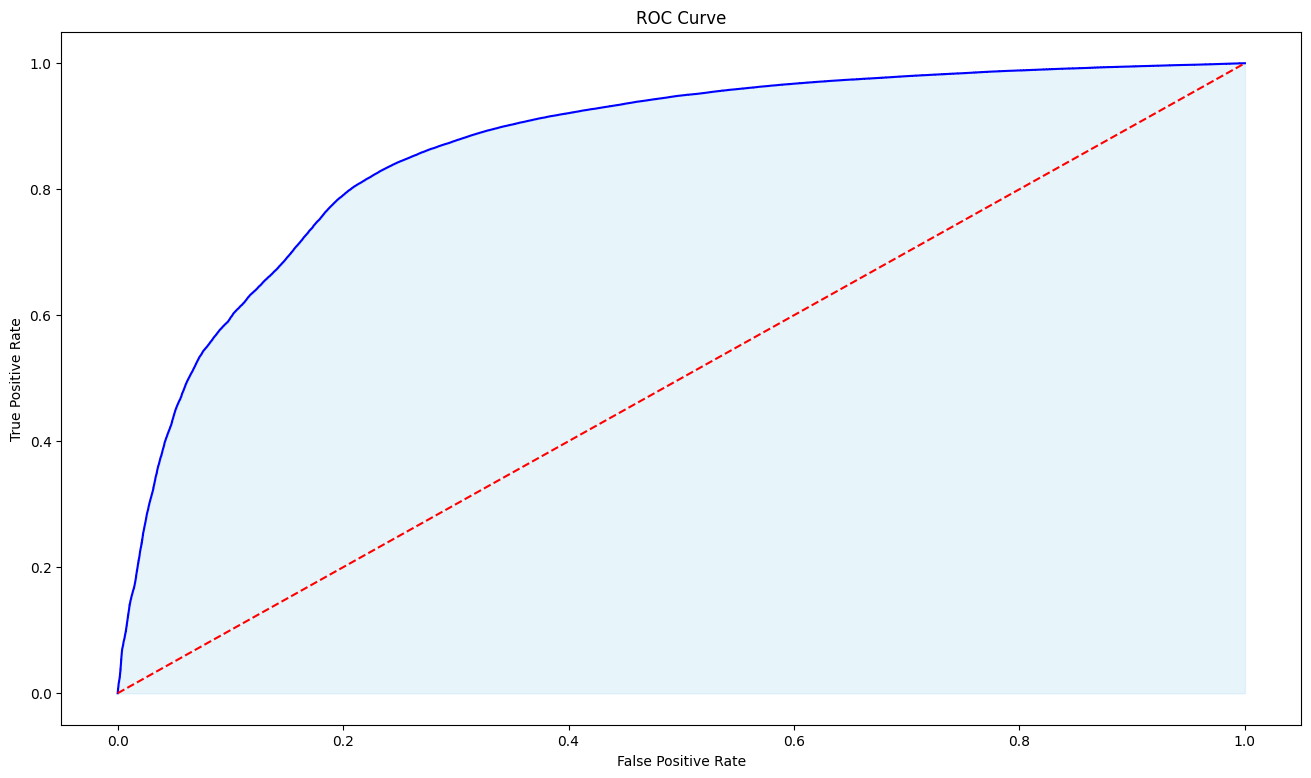

In [49]:
# Initialize logistic regression model with 'sag' solver
lr_model = LogisticRegression()
# (solver='sag', C=1.0, max_iter=10000, penalty='l2',class_weight = 'balanced' )

# Train the model
lr_model.fit(train_balanced, train_labels_balanced)

# Predictions
y_pred = lr_model.predict(test)
y_pred_proba = lr_model.predict_proba(test)[:, 1]
# Calculate F1-score
f1 = f1_score(test_labels, y_pred)
auc_score = roc_auc_score(test_labels, y_pred_proba)


# Print the F1-score (Note: No need for a probability array for F1-score)
print(f"F1 Score: {f1}")
print(f"AUC Score: {auc_score}")

evaluate()

In [50]:
results.append({"Model": 'Logistic Regression', "F1 Score": f1, "AUC": auc_score})


F1 Score: 0.9168441883255702
AUC Score: 0.9686335511855362


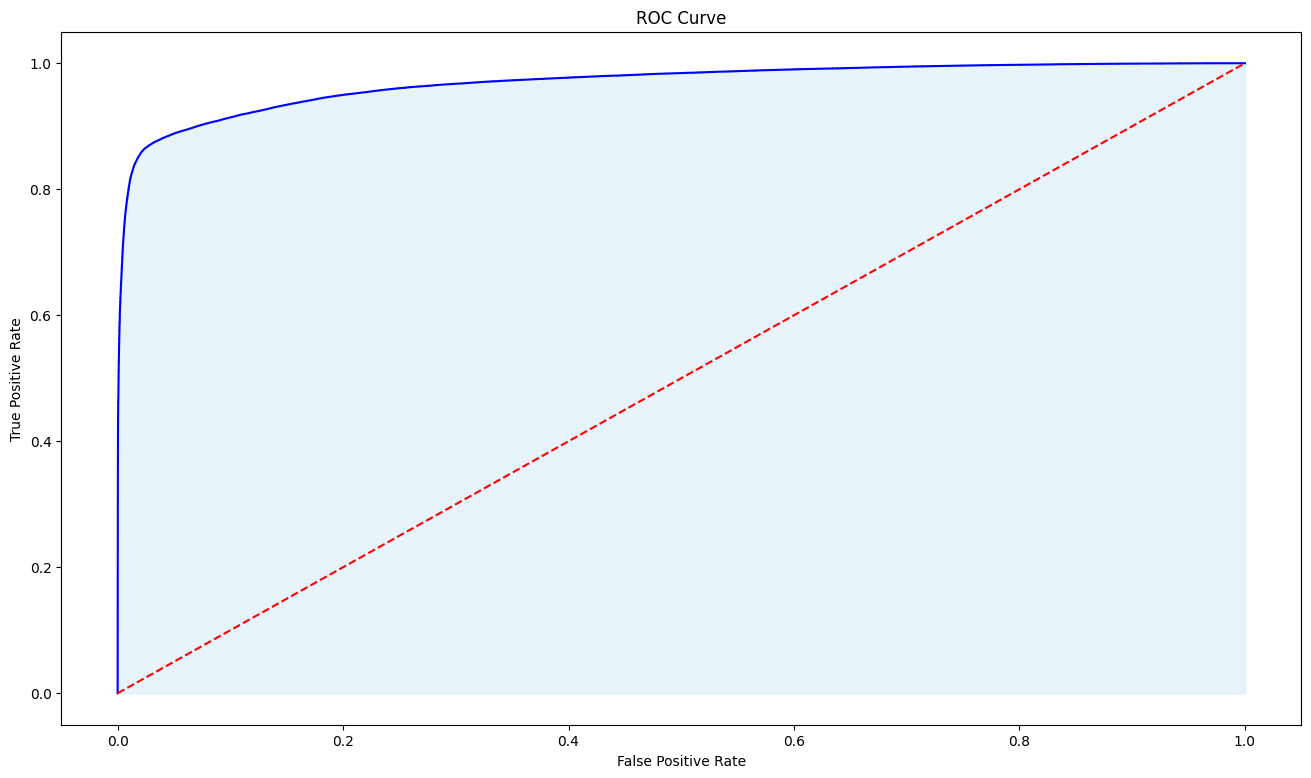

In [51]:
# params = {'eta': 0.2,
#           'max_depth': 15,
#           'subsample': 0.7,
#           'colsample_bytree': 0.9,
#           'objective': 'binary:logistic',
#           'eval_metric': 'auc',
#           'n_jobs': 24,
#           'n_estimators': 400
#           }

# Initialize XGBoost Classifier with selected parameters
class_weight={0:1,1:19}
pos_weight = sum(class_weight.values())/sum(class_weight.keys())
xgb_model = xgb.XGBClassifier()
# (scale_pos_weight = pos_weight, class_weight = class_weight, **params)

# Perform cross-validation
cv_scores = cross_val_score(xgb_model, train_balanced, train_labels_balanced, cv=5, scoring='roc_auc')

# Train the model on the entire training set
xgb_model.fit(train_balanced, train_labels_balanced)

# Predictions on the test set
xgb_y_pred = xgb_model.predict(test)
y_pred_proba = xgb_model.predict_proba(test)[:, 1]


# Calculate F1-score
f1 = f1_score(test_labels, xgb_y_pred)
auc_score = roc_auc_score(test_labels, y_pred_proba)


# Print the F1-score (Note: No need for a probability array for F1-score)
print(f"F1 Score: {f1}")
print(f"AUC Score: {auc_score}")

evaluate()

results.append({"Model": 'XGBoost', "F1 Score": f1, "AUC": auc_score})

In [52]:
# params = {'num_leaves': 127,
#           'min_data_in_leaf': 32,
#           'objective': 'binary',
#           'max_depth': -1,
#           'learning_rate': 0.1,
#           'min_child_samples': 20,
#           'boosting': 'gbdt',
#           'feature_fraction': 0.8,
#           'bagging_freq': 1,
#           'bagging_fraction': 0.8,
#           'bagging_seed': 11,
#           'metric': 'auc',
#           'lambda_l1': 0.1,
#           'verbosity': -1,
#           'n_estimators': 200,
#           'class_weight' : 'balanced'
#           }

# Initialize LightGBM Classifier with selected parameters
lgb_model = lgb.LGBMClassifier()
# (**params)

# Perform cross-validation
cv_scores = cross_val_score(lgb_model, train_balanced, train_labels_balanced, cv=5, scoring='roc_auc')

# Train the model on the entire training set
lgb_model.fit(train_balanced, train_labels_balanced)

# Predictions on the test set
lgb_y_pred = lgb_model.predict(test)
y_pred_proba = lgb_model.predict_proba(test)[:, 1]

# Calculate F1-score
f1 = f1_score(test_labels, lgb_y_pred)
lgb_auc_score = roc_auc_score(test_labels, y_pred_proba)


# Print the F1-score (Note: No need for a probability array for F1-score)
print(f"F1 Score: {f1}")
print(f"AUC Score: {lgb_auc_score}")

print(f"Cross-Validation ROC-AUC Scores: {cv_scores}")
print(f"Average Cross-Validation ROC-AUC Score: {np.mean(cv_scores)}")
results.append({"Model": 'Light GBM', "F1 Score": f1, "AUC": lgb_auc_score})

[LightGBM] [Info] Number of positive: 258190, number of negative: 258190
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.342612 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3502
[LightGBM] [Info] Number of data points in the train set: 516380, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 258190, number of negative: 258191
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.358748 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3498
[LightGBM] [Info] Number of data points in the train set: 516381, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499999 -> initscore=-0.000004
[LightGBM] [Info] Start training from score -0.000004
[LightGBM] [Info] Number of positive: 258190, number of negat

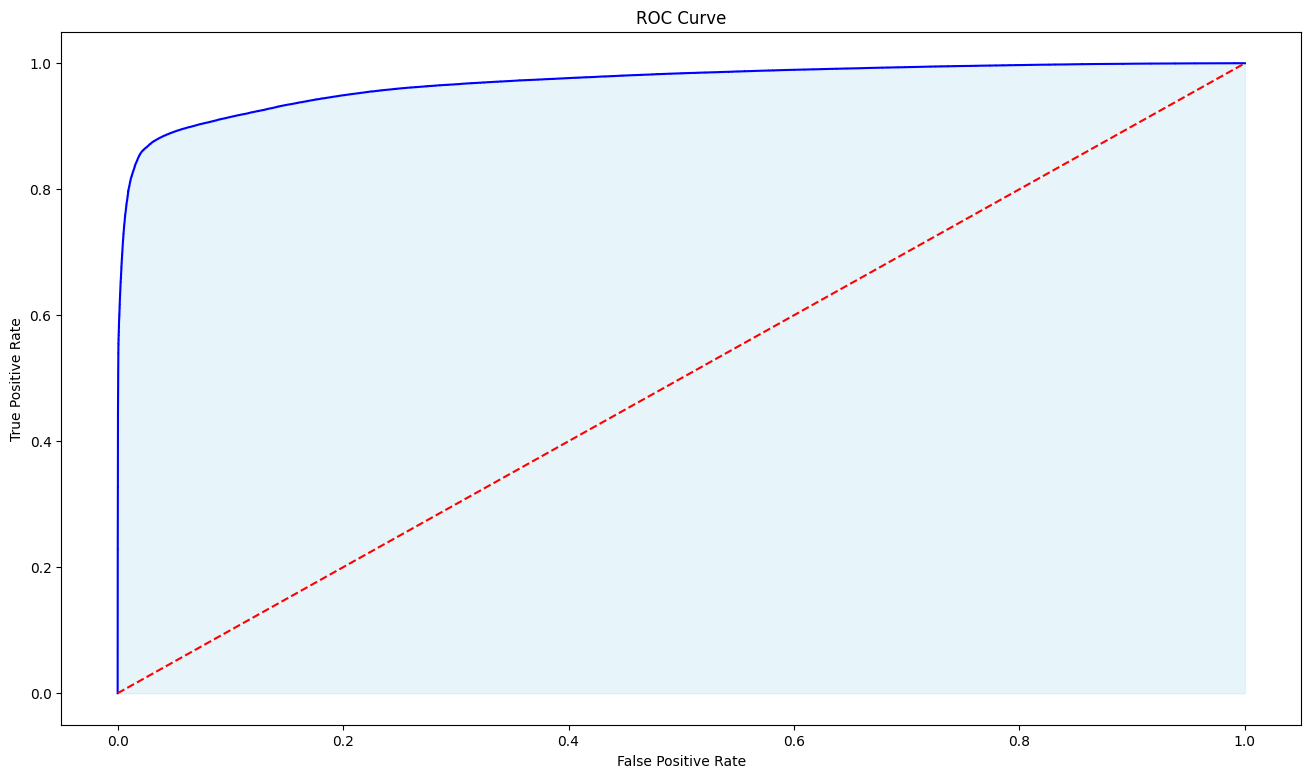

In [53]:
evaluate()





F1 Score: 0.9140989623024223
AUC Score: 0.9686335511855362
Cross-Validation ROC-AUC Scores: [0.973739   0.97386858 0.97356485 0.97391985 0.97316187]
Average Cross-Validation ROC-AUC Score: 0.9736508308387133


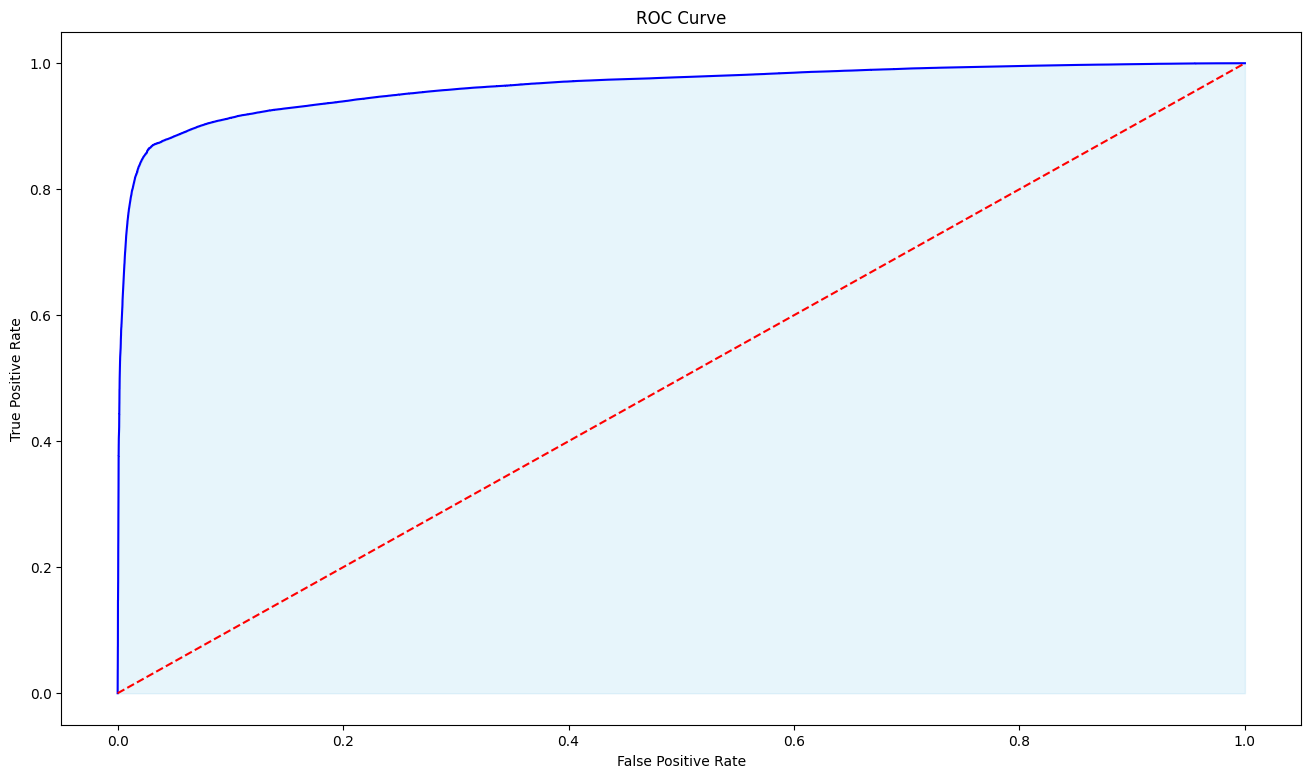

In [54]:
# Manually select parameters from the parameter grid
# params = {
#     'n_estimators': 200,
#     'learning_rate': 0.1,
#     'max_depth': 5,
#     'min_samples_split': 4,
#     'min_samples_leaf': 2,
#     'max_features': 'sqrt'
# }

# Initialize Gradient Boosting Classifier with selected parameters
gb_model = GradientBoostingClassifier()
# (**params)

# Perform cross-validation
# cv_scores = cross_val_score(gb_model, train_balanced, train_labels_balanced, cv=5, scoring='roc_auc')

# Train the model on the entire training set
gb_model.fit(train_balanced, train_labels_balanced)

# Predictions on the test set
gb_y_pred = gb_model.predict(test)
y_pred_proba = gb_model.predict_proba(test)[:, 1]

# Calculate F1-score
f1 = f1_score(test_labels, gb_y_pred)
gb_auc_score = roc_auc_score(test_labels, y_pred_proba)


# Print the F1-score (Note: No need for a probability array for F1-score)
print(f"F1 Score: {f1}")
print(f"AUC Score: {auc_score}")

print(f"Cross-Validation ROC-AUC Scores: {cv_scores}")
print(f"Average Cross-Validation ROC-AUC Score: {cv_scores.mean()}")

evaluate()
results.append({"Model": 'Gradient Boosting Tree', "F1 Score": f1, "AUC": gb_auc_score})

In [55]:
# import optuna
# from sklearn.ensemble import GradientBoostingClassifier

# def objective(trial):
#     hyperparameters = {
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
#         'n_estimators': trial.suggest_int('n_estimators', 50, 500),
#         'max_depth': trial.suggest_int('max_depth', 3, 10),
#         'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
#         'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
#         'subsample': trial.suggest_uniform('subsample', 0.5, 1.0)
#     }
    
#     model = GradientBoostingClassifier(**hyperparameters)
#     scores = cross_val_score(model, train_balanced, train_labels_balanced, cv=5, scoring='roc_auc')
#     return np.mean(scores)

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=10) 


# best_params = study.best_params
# print("Best params found:", best_params)

Learning rate set to 0.148379
0:	learn: 0.5263913	total: 272ms	remaining: 4m 31s
1:	learn: 0.4231380	total: 424ms	remaining: 3m 31s
2:	learn: 0.3641963	total: 582ms	remaining: 3m 13s
3:	learn: 0.3265114	total: 736ms	remaining: 3m 3s
4:	learn: 0.2986835	total: 905ms	remaining: 3m
5:	learn: 0.2803254	total: 1.1s	remaining: 3m 2s
6:	learn: 0.2681824	total: 1.22s	remaining: 2m 53s
7:	learn: 0.2589764	total: 1.32s	remaining: 2m 44s
8:	learn: 0.2520303	total: 1.43s	remaining: 2m 36s
9:	learn: 0.2455766	total: 1.53s	remaining: 2m 31s
10:	learn: 0.2417879	total: 1.64s	remaining: 2m 27s
11:	learn: 0.2377024	total: 1.74s	remaining: 2m 23s
12:	learn: 0.2346152	total: 1.85s	remaining: 2m 20s
13:	learn: 0.2323136	total: 1.95s	remaining: 2m 17s
14:	learn: 0.2289411	total: 2.04s	remaining: 2m 14s
15:	learn: 0.2271838	total: 2.15s	remaining: 2m 12s
16:	learn: 0.2256736	total: 2.25s	remaining: 2m 10s
17:	learn: 0.2241390	total: 2.34s	remaining: 2m 7s
18:	learn: 0.2227718	total: 2.45s	remaining: 2m 6s
1

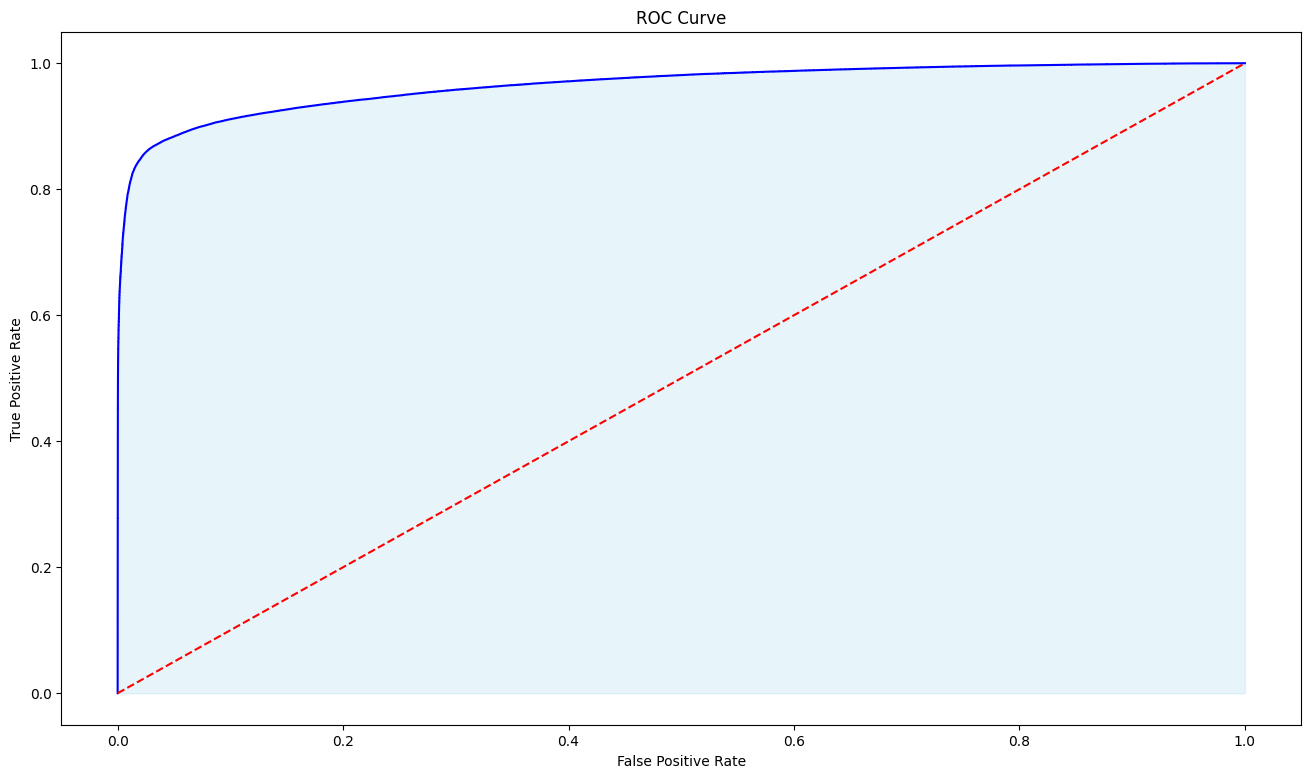

In [56]:
from catboost import CatBoostClassifier

# Manually select parameters from the parameter grid
params = {
    'depth': 10,
    'learning_rate': 0.2,
    'iterations': 500,
    'l2_leaf_reg': 3,
    'border_count': 50,
    'bagging_temperature': 0.04019881483063329,
    'loss_function': 'Logloss',
    'od_type': 'Iter',
    'od_wait': 50,
    'verbose': False
}

# Initialize CatBoost Classifier with selected parameters
cat_model = CatBoostClassifier()
# (**params)

# Perform cross-validation
cv_scores = cross_val_score(cat_model, train_balanced, train_labels_balanced, cv=5, scoring='roc_auc')

# Train the model on the entire training set
cat_model.fit(train_balanced, train_labels_balanced)

# Predictions on the test set
cat_y_pred = cat_model.predict(test)
y_pred_proba = cat_model.predict_proba(test)[:, 1]

# Calculate F1-score
f1 = f1_score(test_labels, cat_y_pred)
cat_auc_score = roc_auc_score(test_labels, y_pred_proba)


# Print the F1-score (Note: No need for a probability array for F1-score)
print(f"F1 Score: {f1}")
print(f"AUC Score: {cat_auc_score}")
print(f"Cross-Validation ROC-AUC Scores: {cv_scores}")
print(f"Average Cross-Validation ROC-AUC Score: {np.mean(cv_scores)}")

evaluate()
results.append({"Model": 'CatBoost', "F1 Score": f1, "AUC": cat_auc_score})

Cross-Validation ROC-AUC Scores: [0.97151739 0.97181545 0.97090825 0.97148231 0.97095088]
Average Cross-Validation ROC-AUC Score: 0.9713348543831483


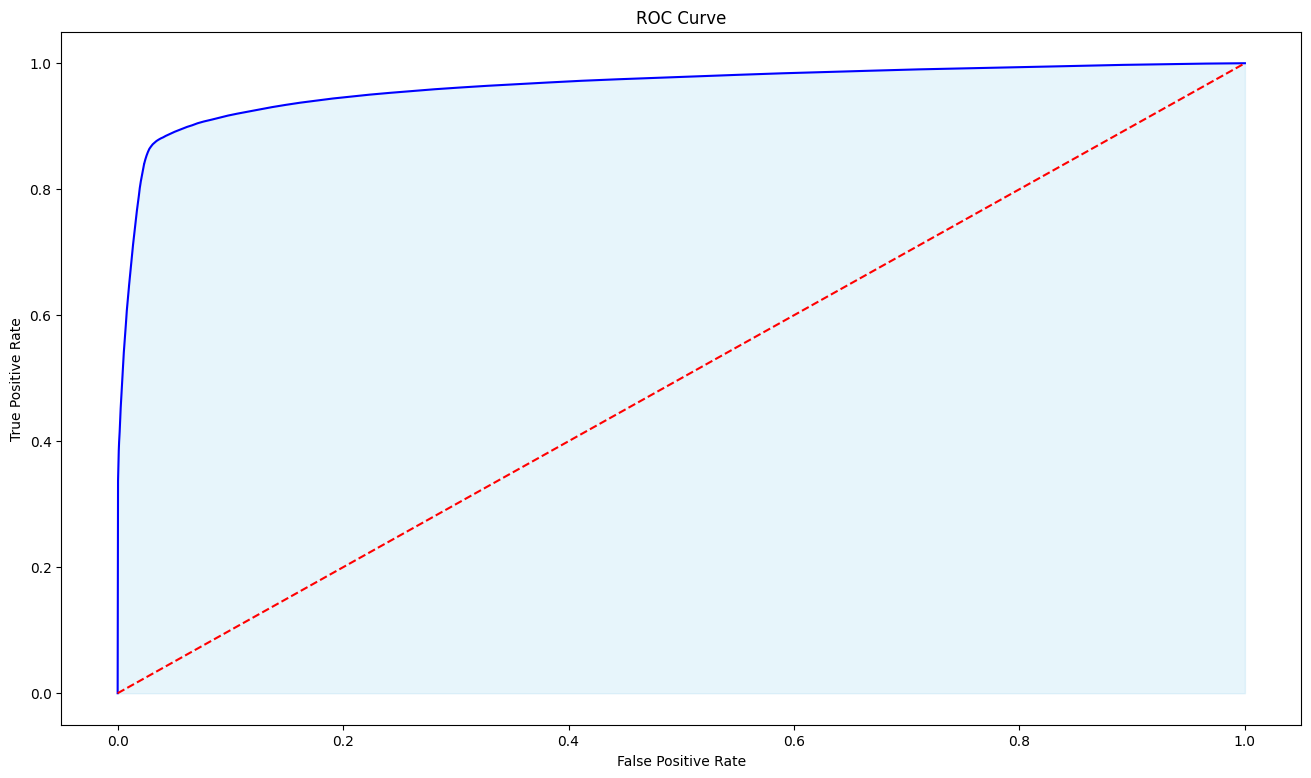

In [57]:
# Initialize Random Forest Classifier
rf_model = RandomForestClassifier()
#     n_estimators=100,
#     max_depth=20,
#     min_samples_split=2,
#     min_samples_leaf=1,
#     max_features='sqrt',
#     bootstrap=False,
#     criterion='gini'
# )

# Perform cross-validation
cv_scores = cross_val_score(rf_model, train_balanced, train_labels_balanced, cv=5, scoring='roc_auc')

# Train the model on the entire training set
rf_model.fit(train_balanced, train_labels_balanced)

# Predictions on the test set
rf_y_pred = rf_model.predict(test)
y_pred_proba = rf_model.predict_proba(test)[:, 1]

# Calculate accuracy and AUC Score on the test set
f1 = f1_score(test_labels, cat_y_pred)
rf_auc_score = roc_auc_score(test_labels, y_pred_proba)

print(f"Cross-Validation ROC-AUC Scores: {cv_scores}")
print(f"Average Cross-Validation ROC-AUC Score: {np.mean(cv_scores)}")

evaluate()
results.append({"Model": 'Random Forest', "F1 Score": f1, "AUC": rf_auc_score})

Cross-Validation ROC-AUC Scores: [0.96084919 0.96152432 0.96068256 0.96161417 0.96058366]
Average Cross-Validation ROC-AUC Score: 0.9610507806099593


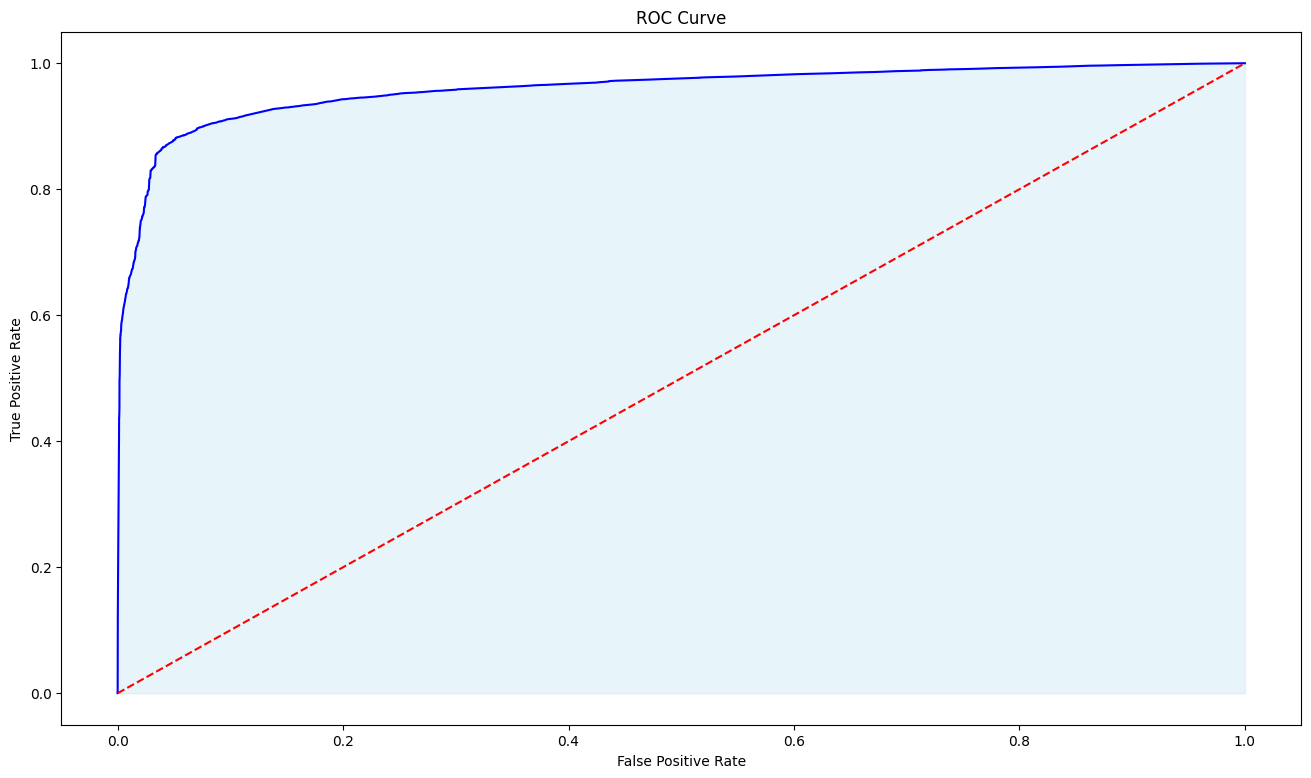

In [58]:
# model performance on test data with chosen hyperparameters

# base estimator
tree = DecisionTreeClassifier()
# (max_depth=2)

# adaboost with the tree as base estimator
# learning rate is arbitrarily set, we'll discuss learning_rate below
ABC_model = AdaBoostClassifier()
#     base_estimator=tree,
#     learning_rate=1.0,
#     n_estimators=300,
#     algorithm="SAMME")

# Perform cross-validation
cv_scores = cross_val_score(ABC_model, train_balanced, train_labels_balanced, cv=5, scoring='roc_auc')

# Train the model on the entire training set
ABC_model.fit(train_balanced, train_labels_balanced)

# Predictions on the test set
ABC_y_pred = ABC_model.predict(test)
y_pred_proba = ABC_model.predict_proba(test)[:, 1]

# Calculate accuracy and AUC Score on the test set
f1 = f1_score(test_labels, ABC_y_pred)

ABC_auc_score = roc_auc_score(test_labels, y_pred_proba)

print(f"Cross-Validation ROC-AUC Scores: {cv_scores}")
print(f"Average Cross-Validation ROC-AUC Score: {np.mean(cv_scores)}")

evaluate()
results.append({"Model": 'AdaBoost', "F1 Score": f1, "AUC": ABC_auc_score})

[LightGBM] [Info] Number of positive: 322738, number of negative: 322738
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.504525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3486
[LightGBM] [Info] Number of data points in the train set: 645476, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Learning rate set to 0.163212
0:	learn: 0.5132333	total: 150ms	remaining: 2m 30s
1:	learn: 0.4072733	total: 340ms	remaining: 2m 49s
2:	learn: 0.3498146	total: 537ms	remaining: 2m 58s
3:	learn: 0.3108495	total: 691ms	remaining: 2m 52s
4:	learn: 0.2880374	total: 824ms	remaining: 2m 44s
5:	learn: 0.2716875	total: 948ms	remaining: 2m 37s
6:	learn: 0.2610493	total: 1.08s	remaining: 2m 32s
7:	learn: 0.2527915	total: 1.21s	remaining: 2m 29s
8:	learn: 0.2456936	total: 1.36s	remaining: 2m 29s
9:	learn: 0.2395861	total: 1.58s	remaining: 2m 36s
10:	learn: 0.23541

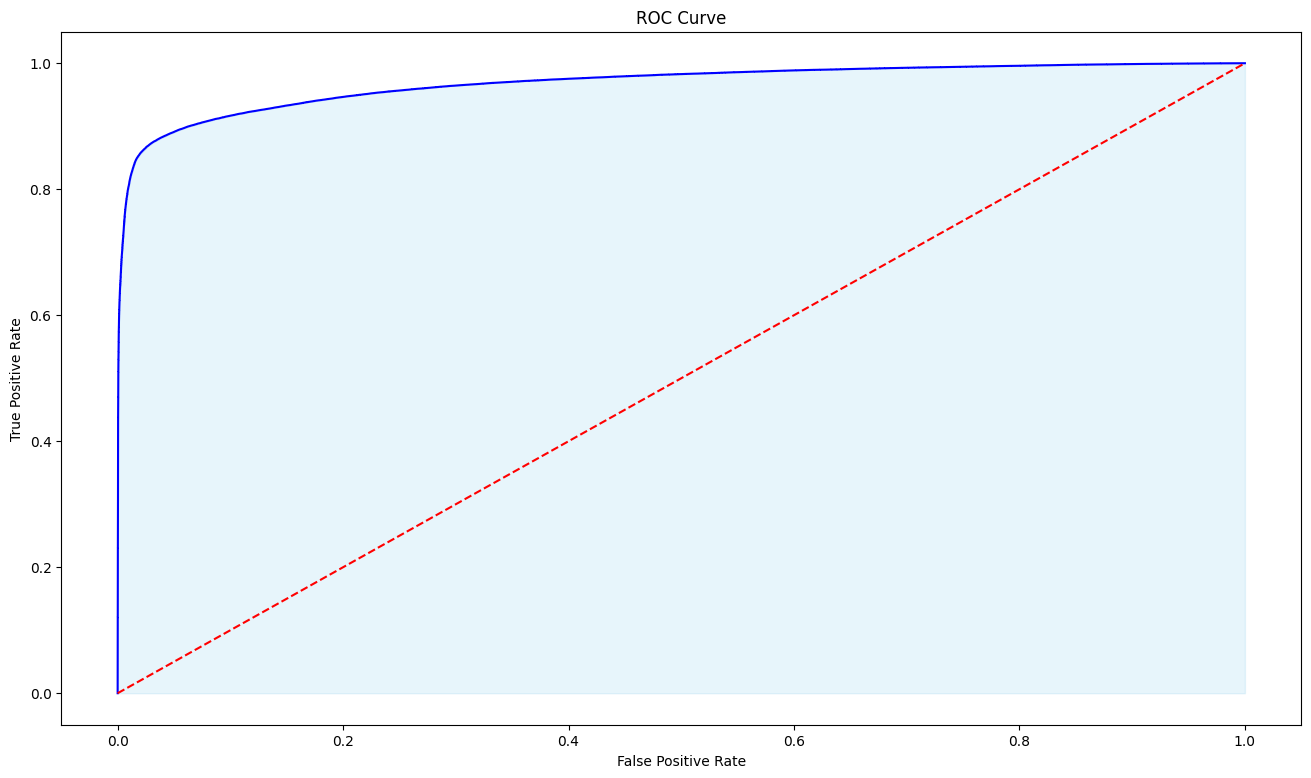

In [59]:
from sklearn.ensemble import StackingClassifier

# Define base models
base_models = [
    ('Logistic Regression', lr_model),
    ('XGBoost', xgb_model),
    ('Gradient Boosting', gb_model),
    ('LightGBM', lgb_model),
    ('CatBoost', cat_model),
    ('RF', rf_model),
    ('AdaBoost', ABC_model)
]

# Define meta-model
meta_model = LogisticRegression()

# Initialize Stacking Classifier
stacked_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

# Train the stacked model (Note: The pre-trained model won't be re-trained)
stacked_model.fit(train_balanced, train_labels_balanced)

# Predictions and evaluation
y_pred = stacked_model.predict(test)
y_pred_proba = stacked_model.predict_proba(test)[:, 1]  # Probabilities for the positive class

# Calculate accuracy and AUC Score
f1 = f1_score(test_labels, y_pred)
auc_score = roc_auc_score(test_labels, y_pred_proba)

print(f"AUC Score: {auc_score}")
evaluate()
results.append({"Model": 'Stacked Model', "F1 Score": f1, "AUC": auc_score})

AUC Score: 0.9218377205158053


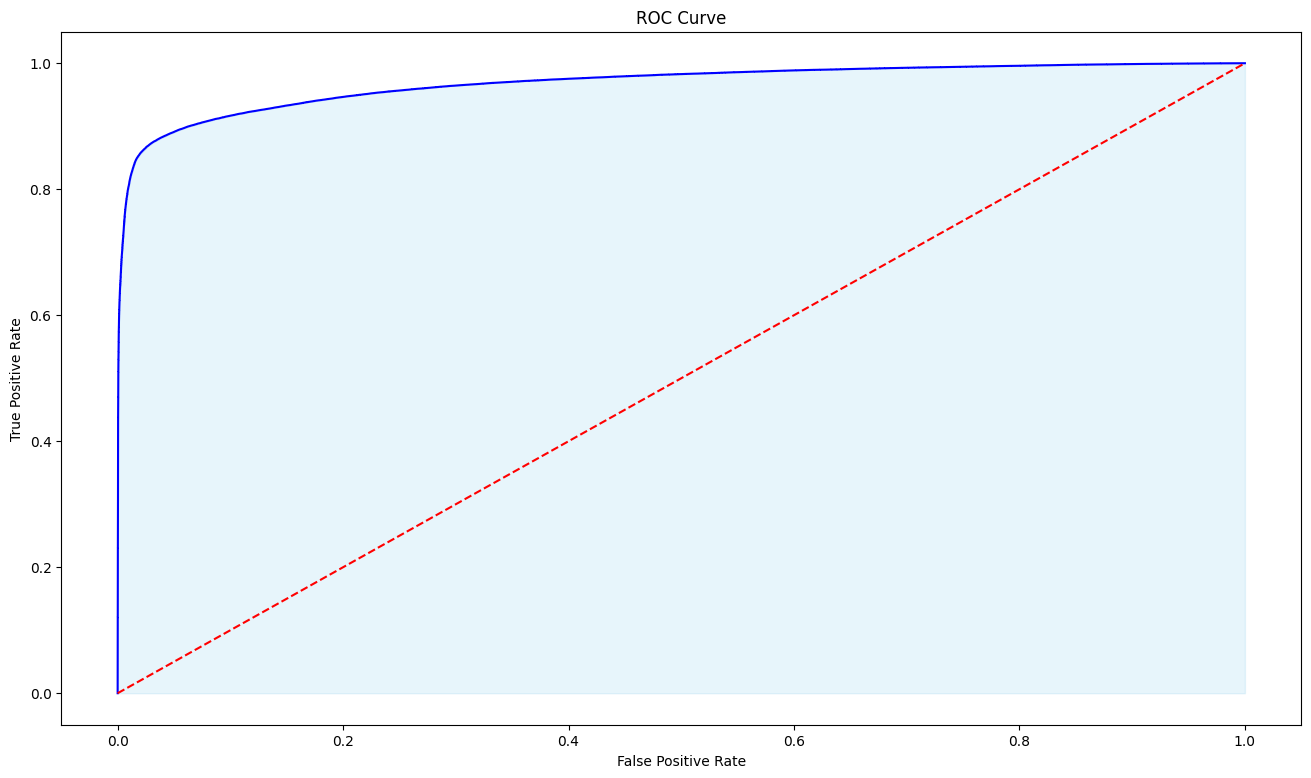

In [60]:
from scipy.stats import mode

# Stack predictions for ease of calculation
stacked_predictions = np.column_stack((gb_y_pred, xgb_y_pred, lgb_y_pred, cat_y_pred, ABC_y_pred))

# Perform majority voting
majority_votes = mode(stacked_predictions, axis=1)[0]

# Flatten to get a 1D array of final predictions
final_predictions = np.ravel(majority_votes)

# Calculate accuracy and AUC Score
f1 = f1_score(test_labels, final_predictions)
auc_score = roc_auc_score(test_labels, final_predictions)
print(f"AUC Score: {auc_score}")
evaluate()
results.append({"Model": 'Majority Vote', "F1 Score": f1, "AUC": auc_score})

AUC Score: 0.9678512673417184


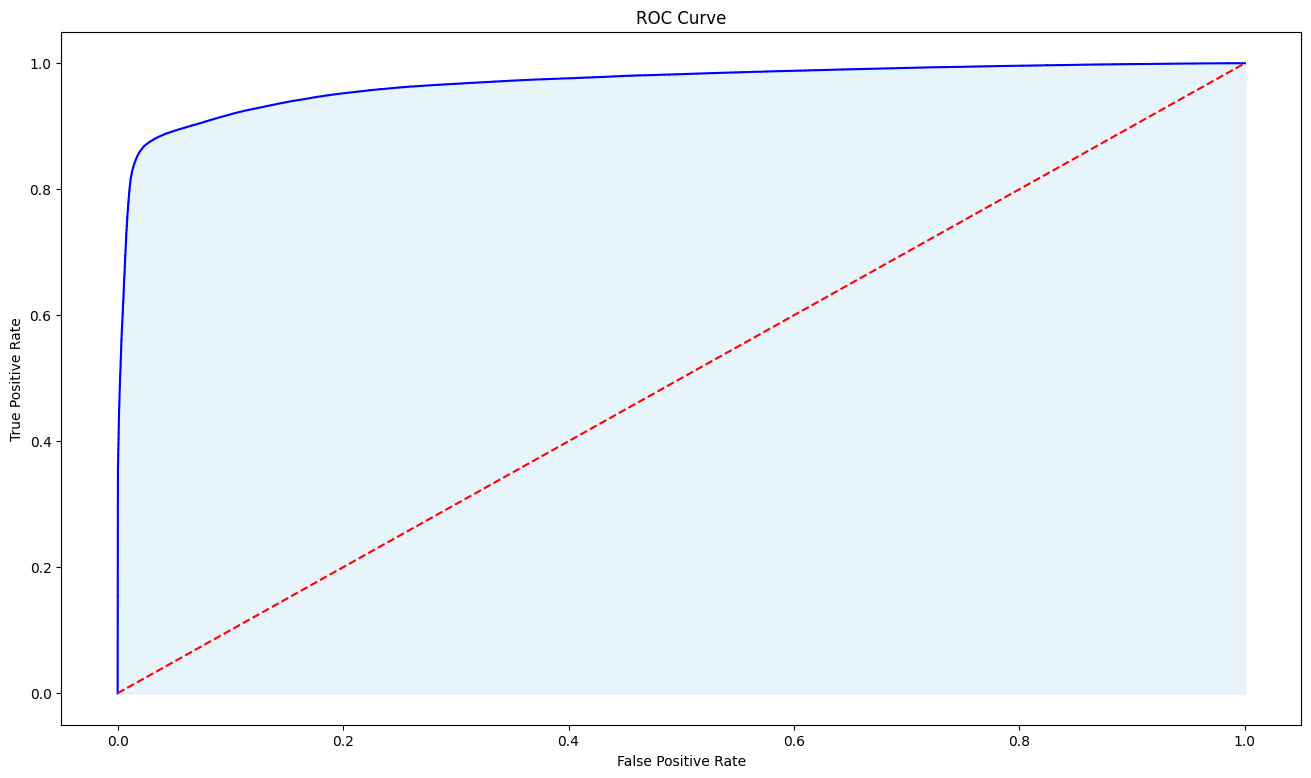

In [61]:
# Define base models
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Define and train XGBoost model
xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42)
xgb_model.fit(train_balanced, train_labels_balanced)  

# Define and train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(train_balanced, train_labels_balanced) 

base_models = [
    ('XGBoost', xgb_model),
    ('Random Forest', rf_model),
]

# Define meta-model
meta_model = LogisticRegression()

# Initialize Stacking Classifier
stacked_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

# Train the stacked model (Note: The pre-trained model won't be re-trained)
stacked_model.fit(train_balanced, train_labels_balanced)

# Predictions and evaluation
y_pred = stacked_model.predict(test)
y_pred_proba = stacked_model.predict_proba(test)[:, 1]  # Probabilities for the positive class

# Calculate accuracy and AUC Score
f1 = f1_score(test_labels, y_pred)
auc_score = roc_auc_score(test_labels, y_pred_proba)

print(f"AUC Score: {auc_score}")
results.append({"Model": 'XGBoost + Random Forest', "F1 Score": f1, "AUC": auc_score})
evaluate()


In [62]:
results = pd.DataFrame(results)
results

,Model,F1 Score,AUC
0,Logistic Regression,0.805369,0.867194
1,XGBoost,0.916844,0.968634
2,Light GBM,0.918575,0.968428
3,Gradient Boosting Tree,0.914099,0.962988
4,CatBoost,0.914058,0.964776
5,Random Forest,0.914058,0.962136
6,AdaBoost,0.908525,0.958807
7,Stacked Model,0.918140,0.967519
8,Majority Vote,0.918268,0.921838
9,XGBoost + Random Forest,0.919272,0.967851
